# Trp-cage

In [3]:
import pyemma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import multiprocessing
from collections import Counter
import copy
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

# NMM modules
import sys
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

## Auxiliary functions

In [2]:
def get_tps(trajs, ini_state, final_state, n_states, misfolded_state=[]):
    
    macro_dict = dict()
    for micro in ini_state:
        macro_dict[micro] = 0
    for micro in final_state:
        macro_dict[micro] = 2
    for micro in [x for x in range(n_states) if x not in ini_state+final_state]:
        macro_dict[micro] = 1
    
    tps_list=[]
    for traj in trajs:
        if isinstance(traj, np.ndarray): traj = traj.tolist()
        macro_traj = list(map(macro_dict.get, traj))
        tp=[]
        for i in range(0,len(macro_traj)):
            if macro_traj[i] == 0:
                tp = [traj[i]]
            elif macro_traj[i] == 2 and len(tp)>0:
                tp.append(traj[i])
                tps_list.append(np.array(tp))
                tp=[]
            elif len(tp)>0:
                tp.append(traj[i])
                
    if misfolded_state:
        tps_list_ = []
        for tps in tps_list:
            if not [microst for microst in tps if microst in misfolded_state]:
                tps_list_.append(tps)
        tps_list = tps_list_
                
    return(tps_list)

def _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state=[]):
    
    # keep only intermediate fragments (of indirect paths) for counts and mean_length
    tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])

    # pdirect
    pdirect = len([path for path in tps if len(path) == 2]) / len(tps)

    # mean path length (indirect only)
    mean_length = np.mean([len(path) for path in tps_indir])

    # counts (indirect only)
    if len(tps_indir) == 0:
        print('There are no indirect TPs!')
        return pdirect, mean_length, np.nan
    tps_indir_concat = np.concatenate(tps_indir)
    counter = Counter(tps_indir_concat)
    counts = [counter[i] for i in [x for x in range(n_states) if x not in stateA+stateB+misfolded_state]]
    counts = np.array(counts) / len(tps_indir_concat)

    return pdirect, mean_length, counts

def get_tps_stats(tps, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    if len(tps) == 0:
        print('There are no TPs!')
        return np.nan, np.nan, np.nan

    if bootstrap:
        bootstrap_counts = []
        bootstrap_pdirect = []
        bootstrap_mean_length = []
        for bootstrap_ in range(n_samples):
            tps_ = np.random.choice(tps, len(tps))
            
            pdirect, mean_length, counts = _get_tps_stats(tps_, stateA, stateB, n_states, misfolded_state)
            
            bootstrap_pdirect.append(pdirect)
            bootstrap_mean_length.append(mean_length)
            bootstrap_counts.append(counts)

        return bootstrap_pdirect, bootstrap_mean_length, bootstrap_counts
            
    else:
        return _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state)

def get_tps_w_stats(dtrajs, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    tps = get_tps(dtrajs, stateA, stateB, n_states, misfolded_state) + get_tps(dtrajs, stateB, stateA, n_states, misfolded_state)
    pdirect, mean_length, counts = get_tps_stats(tps, stateA, stateB, n_states, bootstrap, n_samples, misfolded_state)
    
    return tps, pdirect, mean_length, counts

def simulate_msm(msm, sim_traj_length=1000000):
    
    np.random.seed()
    traj = msm.simulate(sim_traj_length)
    
    return [traj]

def simulate_hamsm(nm_tmatrix, stateA, stateB, sim_traj_length=3000000):
    
    np.random.seed()
    sim = NonMarkovModel.from_nm_tmatrix(nm_tmatrix, stateA, stateB, sim_length=sim_traj_length, initial_state=stateA[0])
    trajs = sim.trajectories
    
    return trajs

def estimate_simulate_msm(dtrajs, lag, sim_traj_length=1000000):
    
    msm = pyemma.msm.estimate_markov_model(list(dtrajs), lag)
    trajs = simulate_msm(msm, sim_traj_length=sim_traj_length)
    
    return msm, trajs

def estimate_simulate_hamsm(dtrajs, stateA, stateB, hist_length='all', sim_traj_length=3000000):
    
    if hist_length == 'all':
        nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, clean_traj=True)
    else:
        nm_model = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, hist_length=hist_length, clean_traj=True)
    
    trajs = simulate_hamsm(nm_model.nm_tmatrix, stateA, stateB, sim_traj_length)
    
    return nm_model, trajs

def coarsegrain_paths(tps, state_dict, stateA, stateB):

    tps_coarse = []

    for path in tps:
        if isinstance(path, np.ndarray): path = path.tolist()
        path_ = []
        for state in path:
            if state in stateA:
                path_.append(state_dict['A'])
            elif state in stateB:
                path_.append(state_dict['B'])
            else:
                path_.append(state_dict[state])
        if path_[0] == state_dict['B']:
            path_ = path_[::-1]
        tps_coarse.append(path_)
        
    return tps_coarse

def get_fundamental_sequences(tps, stateA, stateB, nm_dict, markov_tmatrix, bootstrap=False, n_samples=1000):
    
    # keep only intermediate fragments (of indirect paths)
    tps_ = [path for path in tps if len(path) > 2]   
    tps_coarse = coarsegrain_paths(tps_, nm_dict, stateA, stateB)
    
    if bootstrap:
        bootstrap_FS = []
        bootstrap_FSweights = []
        for bootstrap in range(n_samples):
            tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))
            
            ens = DiscretePathEnsemble(tps_coarse_, stateA=stateA, stateB=stateB)
            FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)
            
            bootstrap_FS.append(FS)
            bootstrap_FSweights.append(FSweights)
            
        return bootstrap_FS, bootstrap_FSweights    
    
    else:
        ens = DiscretePathEnsemble(tps_coarse, stateA=stateA, stateB=stateB)
        FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)

        return FS, FSweights
    
def get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict):
    
    FSweights_common = np.zeros(len(FS_md))

    for j,seq in enumerate(FS):
        if seq in FS_md_indexdict:
            FSweights_common[FS_md_indexdict[seq]] = FSweights[j]
            
    return FSweights_common

chignolin_membs = np.load('../../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/chignolin_lag150ns_metastable_memberships.npy')
villin_membs = np.load('../../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_lag100ns_metastable_memberships_3states.npy')
trpcage_membs = np.load('../../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/trpcage_lag100ns_metastable_memberships.npy')
ntl9_membs = np.load('../../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/ntl9_lag200ns_metastable_memberships.npy')
def get_metastable_sets(cutoff):
    
    chignolin_sets = [np.concatenate(np.argwhere(chignolin_membs[:,0] >= cutoff)).tolist(),
    np.concatenate(np.argwhere(chignolin_membs[:,1] >= cutoff)).tolist()]
    
    villin_sets = [np.concatenate(np.argwhere(villin_membs[:,2] >= cutoff)).tolist(),
    np.concatenate(np.argwhere(villin_membs[:,1] >= cutoff)).tolist()]

    trpcage_sets = [np.concatenate(np.argwhere(trpcage_membs[:,1] >= cutoff)).tolist(),
    np.concatenate(np.argwhere(trpcage_membs[:,0] >= cutoff)).tolist()]

    ntl9_sets = [np.concatenate(np.argwhere(ntl9_membs[:,0] >= cutoff)).tolist(),
    np.concatenate(np.argwhere(ntl9_membs[:,1] >= cutoff)).tolist()]
    
    # returns [[unfolded], [folded]]
    return (chignolin_sets, villin_sets, trpcage_sets, ntl9_sets)

def abs_error(x,y):

    abs_error = np.sum(np.abs(x-y))
        
    return abs_error

## Read MD data

In [4]:
system_name = 'Trp-cage'

dtrajs = np.load("../../vamp_scoring/automatic_eigenvalue/trpcage/dtrajs_trpcage_lag10ns.npy")

# 10 intermediate microstates
# unfolded
stateA = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 43, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99]

# folded
stateB = [3, 14, 23, 37, 56]

## Estimate MSMs and simulate long trajectories

In [4]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

In [5]:
pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, [(dtrajs, lag) for lag in lags])
pool.close()
pool.join()

msms = [x[0] for x in out]
dtrajs_msms = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms.npy'.format(system_name), dtrajs_msms)
# OR RELOAD
# dtrajs_msms = np.load('{}_dtrajs_msms.npy'.format(system_name), allow_pickle=True)

## Estimate haMSMs and simulate long trajectories

In [6]:
remove_for_eq = int(np.mean([msms[7].mfpt(stateA, stateB), msms[7].mfpt(stateB, stateA)]))
dtrajs_nm = []

dtrajs_ = copy.deepcopy(dtrajs)
for traj in dtrajs_:
    dtrajs_nm.append(traj[remove_for_eq:])
    dtrajs_nm.append(traj[remove_for_eq:][::-1])

np.save('{}_dtrajs_nm.npy'.format(system_name), dtrajs_nm)
# OR RELOAD    
# dtrajs_nm = np.load('{}_dtrajs_nm.npy'.format(system_name), allow_pickle=True)

dtrajs_nm = [x.tolist() for x in dtrajs_nm]

In [9]:
hist_lengths = ['all', 5, 10, 20, 50, 250, 500]
pool = multiprocessing.Pool(7)
out = pool.starmap(estimate_simulate_hamsm, [(dtrajs_nm, stateA, stateB, hist_length) for hist_length in hist_lengths])
pool.close()
pool.join()

hamsms = [x[0] for x in out]
dtrajs_hamsms = [x[1] for x in out]
del out

np.save('{}_dtrajs_hamsms.npy'.format(system_name), dtrajs_hamsms)
# OR RELOAD
# dtrajs_hamsms = np.load('{}_dtrajs_hamsms.npy'.format(system_name), allow_pickle=True)

# 10 intermediate states: p(x|TP) (indirect paths only)

## MD

In [6]:
tps_md, pdirect_md, mean_length_md, counts_md = get_tps_w_stats(dtrajs, stateA, stateB, n_states=100, bootstrap=True, n_samples=1000)

In [7]:
len(tps_md), len([path for path in tps_md if len(path) > 2]) # all, and indirect paths only

(336, 79)

## MSMs

In [12]:
tps_msms = []
pdirect_msms = []
mean_length_msms = []
counts_msms = []

for dtrajs_ in dtrajs_msms:
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_, stateA, stateB, n_states=100)
    
    tps_msms.append(tps)
    pdirect_msms.append(pdirect)
    mean_length_msms.append(mean_length)
    counts_msms.append(counts)

In [13]:
# all paths
[len(tps) for tps in tps_msms]

[942, 1460, 1596, 1912, 2550, 6123, 9970, 17469, 88431]

In [14]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_msms]

[686, 1131, 1266, 1515, 2001, 4335, 6371, 9975, 17738]

## haMSMs

In [15]:
tps_hamsms = []
pdirect_hamsms = []
mean_length_hamsms = []
counts_hamsms = []

for dtrajs_ in dtrajs_hamsms:
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_, stateA, stateB, n_states=100)
    
    tps_hamsms.append(tps)
    pdirect_hamsms.append(pdirect)
    mean_length_hamsms.append(mean_length)
    counts_hamsms.append(counts)

In [16]:
# all paths
[len(tps) for tps in tps_hamsms]

[934]

In [17]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_hamsms]

[229]

## plot

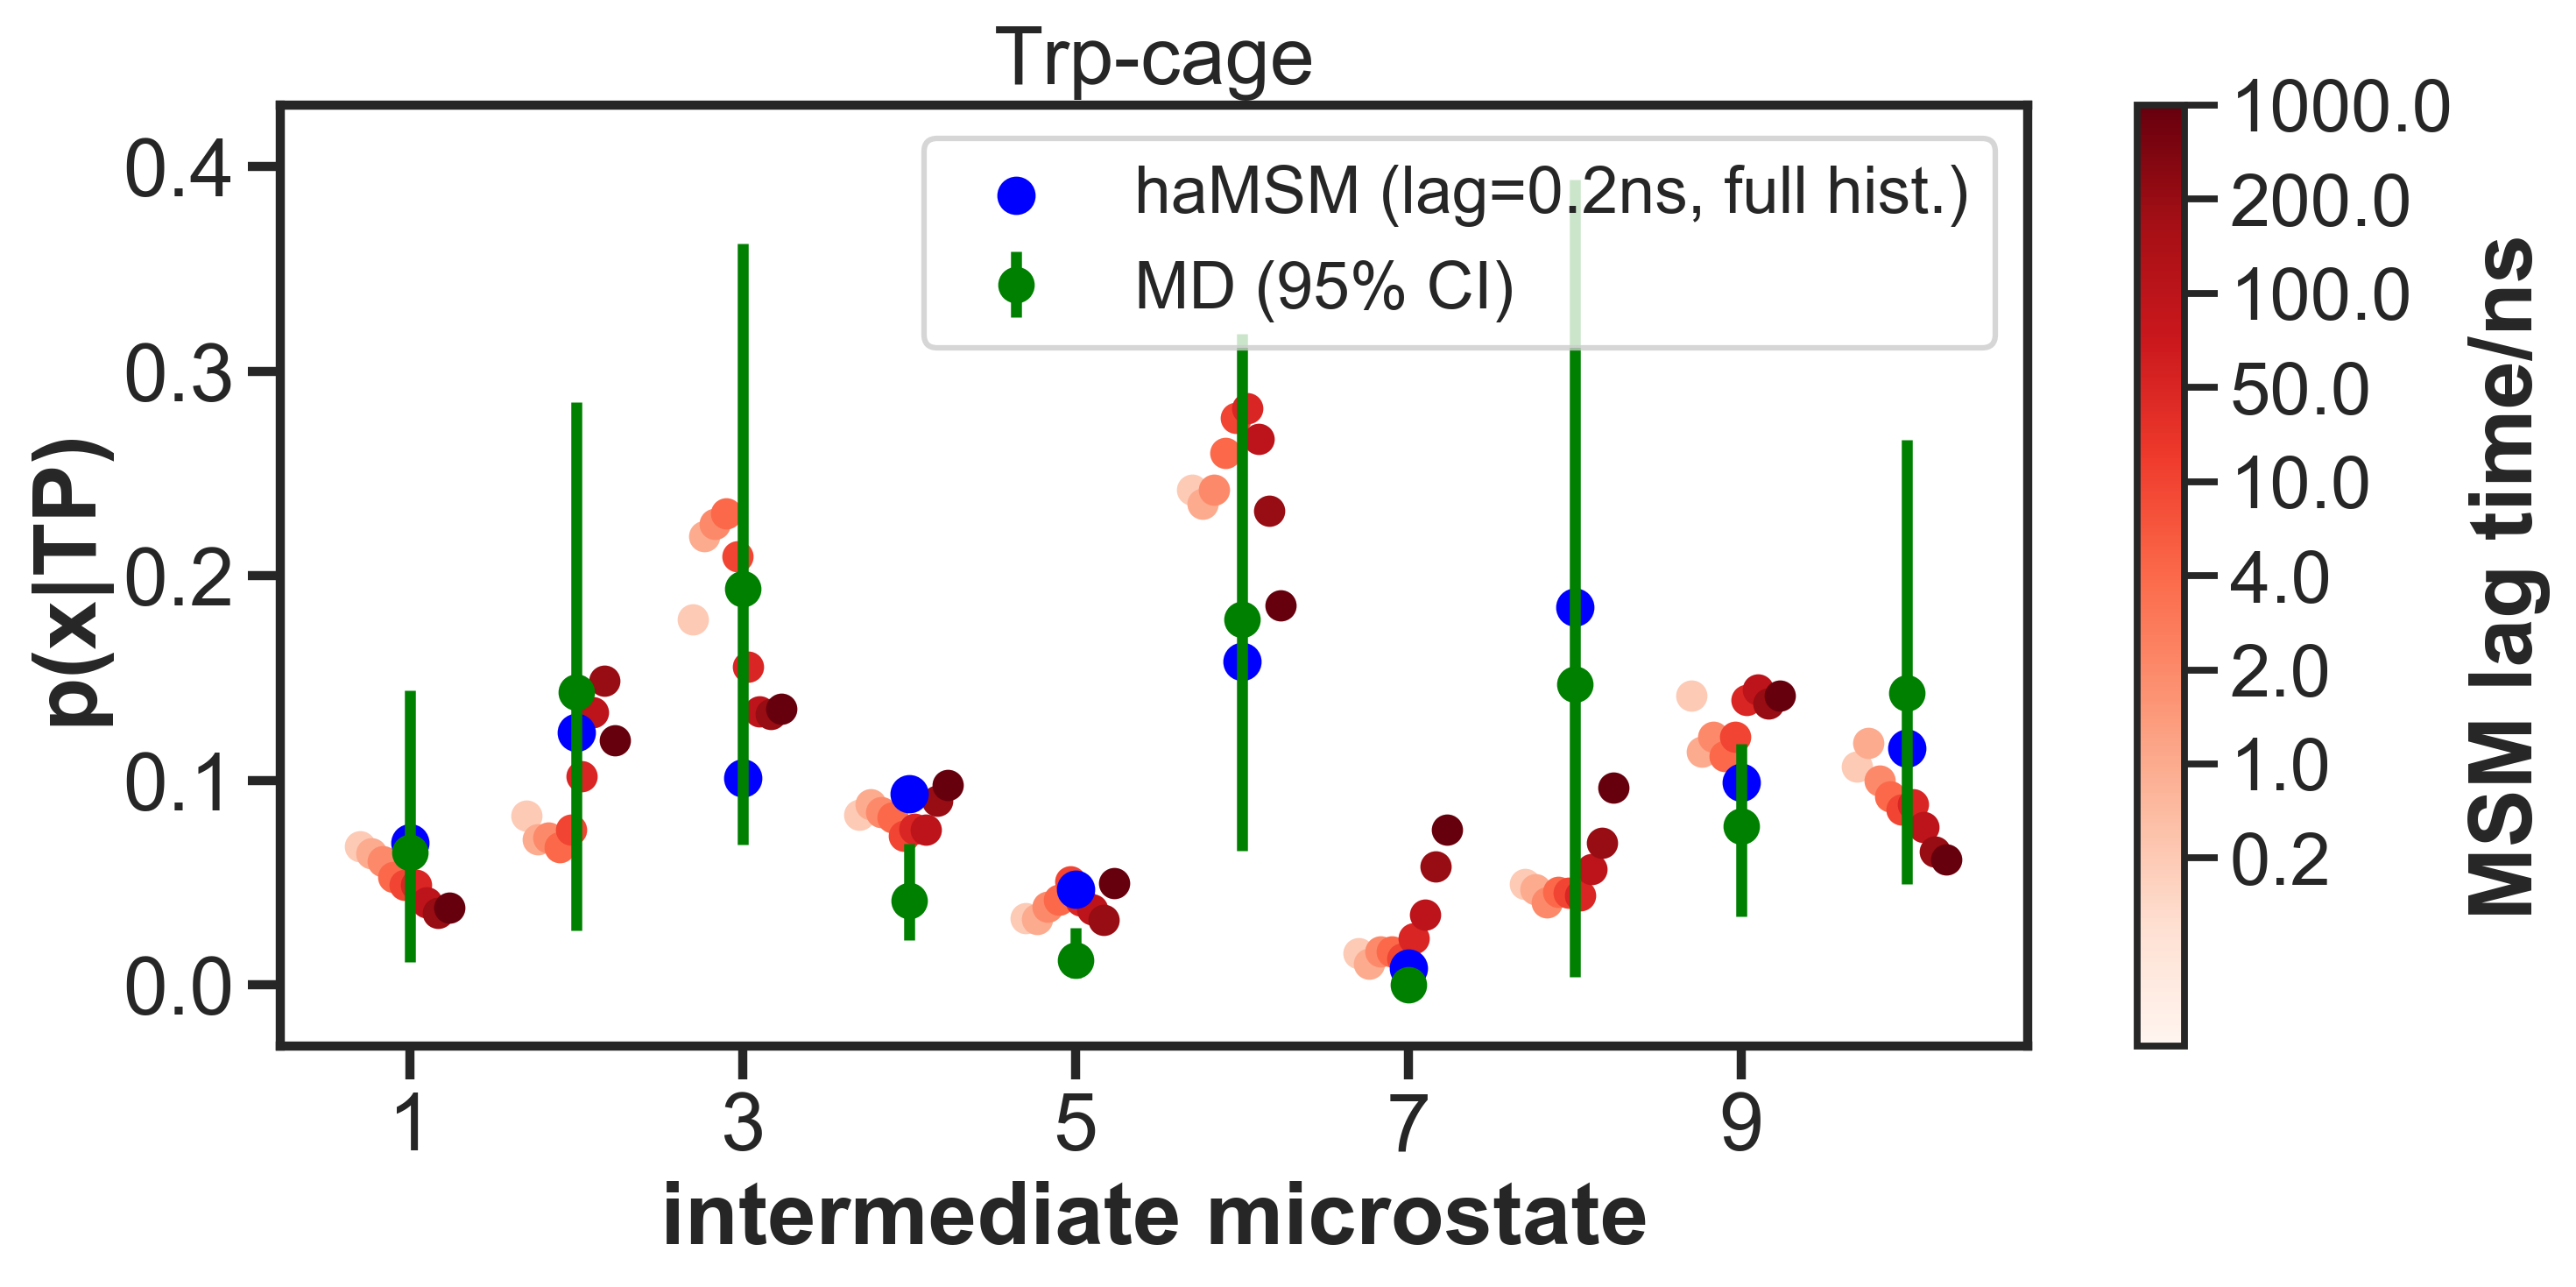

In [18]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msms[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(counts_md, axis=0), 
             yerr=[(np.mean(counts_md, axis=0)-np.percentile(counts_md, 2.5, axis=0)), 
                   (np.percentile(counts_md, 97.5, axis=0)-np.mean(counts_md, axis=0))], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

plt.scatter(np.arange(1,11), counts_hamsms[0], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
#plt.scatter(np.arange(1,11), counts_hamsms[1], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
#plt.scatter(np.arange(1,11), counts_hamsms[4], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('intermediate microstate', fontsize=24, weight='bold')
plt.ylabel('p(x|TP)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,10,2), np.arange(1,10,2), fontsize=22)
plt.yticks(np.arange(0, 0.45, 0.1), fontsize=22)
plt.ylim(-0.03, 0.43)
plt.title('{}'.format(system_name), fontsize=22)
plt.legend(fontsize=18)

plt.tight_layout()
plt.savefig('{}_pxTP_main.pdf'.format(system_name))

plt.show()

# 10 intermediate states: fundamental sequences (indirect paths only)

## new haMSM estimation with coarse macrostates

In [19]:
dtrajs_nm_ = copy.deepcopy(dtrajs_nm) # coarse_macrostates = True modifies dtrajs
nm_model = NonMarkovModel(dtrajs_nm_, stateA, stateB, lag_time=1, coarse_macrostates=True) 

In [21]:
# make micro --> macro dictionary for path coarse-graining
nm_dict = dict()
nm_dict['A'] = nm_model.stateA[0]
nm_dict['B'] = nm_model.stateB[0]

for i in range(len(dtrajs_nm[0])):
    if len(nm_dict) == nm_model.n_states:
        break
    if dtrajs_nm[0][i] not in stateA+stateB:  
        nm_dict[dtrajs_nm[0][i]] = nm_model.trajectories[0][i]

## MD 

In [22]:
FS_md, FSweights_md = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix)

FS_md_bootstrap, FSweights_md_bootstrap = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix, bootstrap=True, n_samples=1000)

## MSMs

In [23]:
FS_msms = []
FSweights_msms = []

for i,tps in enumerate(tps_msms):
    nm_model.lag_time = lags[i]
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_msms.append(FS)
    FSweights_msms.append(FSweights)       

nm_model.lag_time = 1    

## haMSMs

In [24]:
FS_hamsms = []
FSweights_hamsms = []

for i,tps in enumerate(tps_hamsms):
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_hamsms.append(FS)
    FSweights_hamsms.append(FSweights)   

## find common fundamental sequences

In [25]:
FS_md_indexdict = dict()
for i,seq in enumerate(FS_md):
    FS_md_indexdict[seq] = i

# MD
FSweights_md_bootstrap_common = []
for i in range(len(FS_md_bootstrap)):
    FS = FS_md_bootstrap[i]
    FSweights = FSweights_md_bootstrap[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_md_bootstrap_common.append(FSweights_common)            

# MSMs
FSweights_msms_common = []
for i in range(len(FS_msms)):
    FS = FS_msms[i]
    FSweights = FSweights_msms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict) 
    FSweights_msms_common.append(FSweights_common)    

# haMSMs
FSweights_hamsms_common = []
for i in range(len(FS_hamsms)):
    FS = FS_hamsms[i]
    FSweights = FSweights_hamsms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_hamsms_common.append(FSweights_common)     

## plot

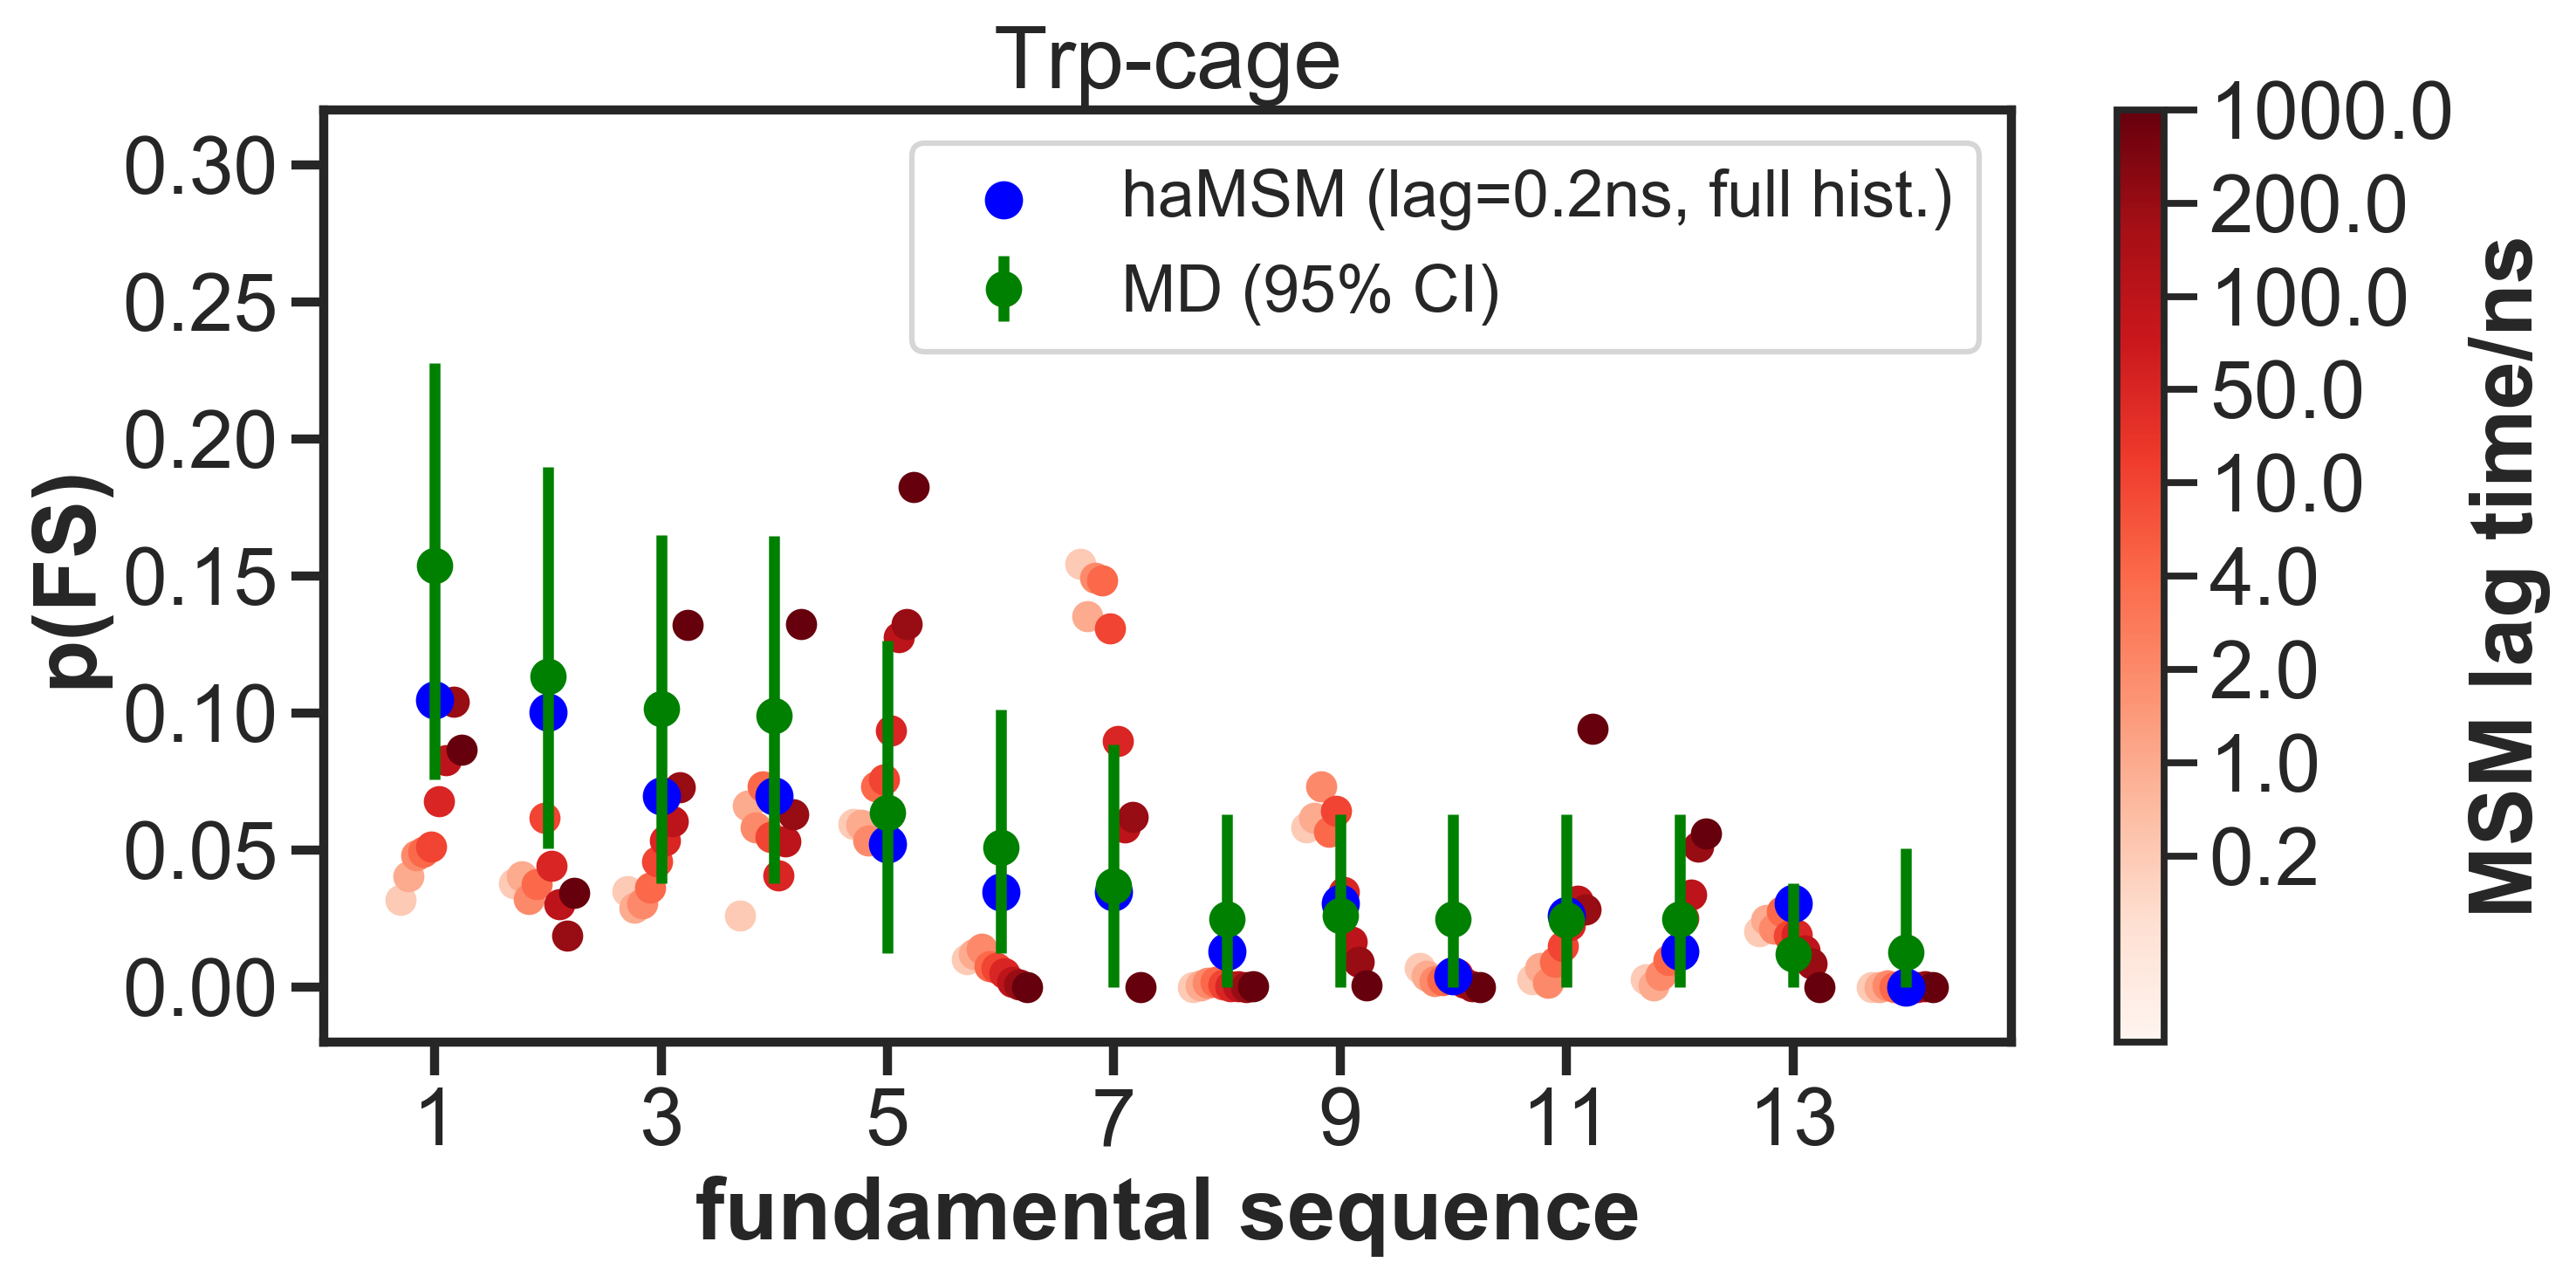

In [26]:
# show all paths with prob. > 0.01 in MD
no_paths = 15

fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,no_paths+0.5), 
                FSweights_msms_common[msm_index][:no_paths], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=22)

plt.errorbar(range(1,no_paths+1), np.mean(FSweights_md_bootstrap_common, axis=0)[:no_paths], 
             yerr=[(np.mean(FSweights_md_bootstrap_common, axis=0)-np.percentile(FSweights_md_bootstrap_common, 2.5, axis=0))[:no_paths], 
                   (np.percentile(FSweights_md_bootstrap_common, 97.5, axis=0)-np.mean(FSweights_md_bootstrap_common, axis=0))[:no_paths]], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[0][:no_paths], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
#plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[1][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
#plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[4][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('fundamental sequence', fontsize=24, weight='bold')
plt.ylabel('p(FS)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,no_paths+1,2), np.arange(1,no_paths+1,2), fontsize=22)
plt.yticks(np.arange(0, 0.35, 0.05), fontsize=22)
plt.ylim(-0.02, 0.32)
plt.title('{}'.format(system_name), fontsize=24)
plt.legend(fontsize=18)

plt.tight_layout()
plt.savefig('{}_pFS_main.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, stride = 0.2 ns

## choose PCCA cutoffs 

In [8]:
cutoffs = [0.89, 0.94, 0.96, 0.97, 0.975, 0.979, 0.981, 0.983, 0.987, 0.993, 0.997]
system_index = 2

intermediate_lens = []

for cutoff in cutoffs:

    stateA_ = list(get_metastable_sets(cutoff)[system_index][0]) # unfolded
    stateB_ = list(get_metastable_sets(cutoff)[system_index][1]) # folded
    
    intermediate_lens.append(100 - (len(stateA_)+len(stateB_)))

In [9]:
intermediate_lens

[4, 7, 10, 14, 20, 34, 52, 67, 76, 86, 93]

## MD

In [10]:
tps_md_cutoffs = []
pdirect_md_cutoffs = []
length_md_cutoffs = []
counts_md_cutoffs = []

for cutoff in cutoffs:
    
    stateA_= list(get_metastable_sets(cutoff)[system_index][0]) # unfolded
    stateB_ = list(get_metastable_sets(cutoff)[system_index][1]) # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs, stateA_, stateB_, n_states=100, bootstrap=True, n_samples=1000)

    tps_md_cutoffs.append(tps)
    pdirect_md_cutoffs.append(pdirect)
    length_md_cutoffs.append(mean_length)
    counts_md_cutoffs.append(counts)

In [11]:
# all paths
[len(tps) for tps in tps_md_cutoffs]

[420, 370, 336, 220, 214, 136, 108, 82, 34, 32, 30]

In [12]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_md_cutoffs]

[59, 69, 79, 75, 72, 61, 70, 67, 34, 32, 30]

## MSMs

In [13]:
tps_msms_cutoffs = []
pdirect_msms_cutoffs = []
length_msms_cutoffs = []
counts_msms_cutoffs = []

for cutoff in cutoffs:
    
    stateA_= list(get_metastable_sets(cutoff)[system_index][0]) # unfolded
    stateB_ = list(get_metastable_sets(cutoff)[system_index][1]) # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs.append(tps_)
    pdirect_msms_cutoffs.append(pdirect_)
    length_msms_cutoffs.append(length_)
    counts_msms_cutoffs.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs = [x * lags for x in length_msms_cutoffs]

In [14]:
# all paths
for i in range(len(cutoffs)):
    print([len(tps) for tps in tps_msms_cutoffs[i]])

[964, 1512, 1622, 1952, 2604, 6259, 10152, 17777, 89325]
[942, 1474, 1600, 1922, 2570, 6163, 10032, 17605, 88925]
[942, 1460, 1596, 1912, 2550, 6123, 9970, 17469, 88431]
[890, 1428, 1552, 1884, 2514, 6025, 9844, 17287, 86541]
[886, 1428, 1552, 1882, 2510, 6015, 9822, 17237, 86049]
[886, 1424, 1552, 1876, 2504, 5965, 9770, 17107, 84271]
[884, 1416, 1546, 1864, 2496, 5903, 9686, 16855, 80109]
[876, 1364, 1498, 1812, 2422, 5747, 9314, 16191, 73441]
[826, 1322, 1432, 1740, 2342, 5517, 8980, 15539, 66793]
[766, 1224, 1328, 1634, 2180, 5217, 8442, 14469, 54872]
[673, 1018, 1182, 1448, 1924, 4703, 7552, 12665, 39506]


In [15]:
# indirect paths only
for i in range(len(cutoffs)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs[i]])

[616, 988, 1076, 1256, 1546, 3220, 4600, 6795, 10786]
[647, 1074, 1210, 1433, 1823, 3980, 5734, 8801, 14091]
[686, 1131, 1266, 1515, 2001, 4335, 6371, 9975, 17738]
[738, 1259, 1376, 1658, 2203, 4637, 6889, 11507, 23477]
[737, 1266, 1384, 1677, 2234, 4842, 7342, 12168, 28668]
[816, 1346, 1472, 1764, 2340, 5398, 8347, 13895, 41442]
[851, 1372, 1502, 1809, 2410, 5658, 9086, 15136, 53655]
[864, 1350, 1480, 1798, 2380, 5657, 9075, 15738, 58023]
[826, 1322, 1432, 1740, 2324, 5465, 8897, 15399, 56720]
[766, 1224, 1328, 1634, 2180, 5210, 8432, 14422, 51040]
[673, 1018, 1182, 1448, 1924, 4703, 7552, 12639, 37811]


## haMSMs: estimate and simulate

In [16]:
pool = multiprocessing.Pool(8)

arguments = []
for cutoff in cutoffs:
    
    stateA_= list(get_metastable_sets(cutoff)[system_index][0]) # unfolded
    stateB_ = list(get_metastable_sets(cutoff)[system_index][1]) # folded
    
    arguments.append((dtrajs_nm, stateA_, stateB_, 'all'))

out = pool.starmap(estimate_simulate_hamsm, arguments)
pool.close()
pool.join()

hamsms_cutoffs = [x[0] for x in out]
dtrajs_hamsms_cutoffs = [x[1] for x in out]
del out

np.save('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), dtrajs_hamsms_cutoffs)
# OR RELOAD
# dtrajs_hamsms_cutoffs = np.load('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), allow_pickle=True)

## haMSMs: count

In [17]:
tps_hamsms_cutoffs = []
pdirect_hamsms_cutoffs = []
length_hamsms_cutoffs = []
counts_hamsms_cutoffs = []

for i,cutoff in enumerate(cutoffs):
    
    stateA_= list(get_metastable_sets(cutoff)[system_index][0]) # unfolded
    stateB_ = list(get_metastable_sets(cutoff)[system_index][1]) # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_hamsms_cutoffs[i], stateA_, stateB_, n_states=100)

    tps_hamsms_cutoffs.append(tps)
    pdirect_hamsms_cutoffs.append(pdirect)
    length_hamsms_cutoffs.append(mean_length)
    counts_hamsms_cutoffs.append(counts)

In [18]:
# all paths
[len(tps) for tps in tps_hamsms_cutoffs]

[1206, 1104, 838, 614, 614, 414, 325, 279, 104, 87, 110]

In [19]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_hamsms_cutoffs]

[161, 194, 190, 209, 178, 174, 213, 233, 104, 87, 110]

## plot: p(direct TP)

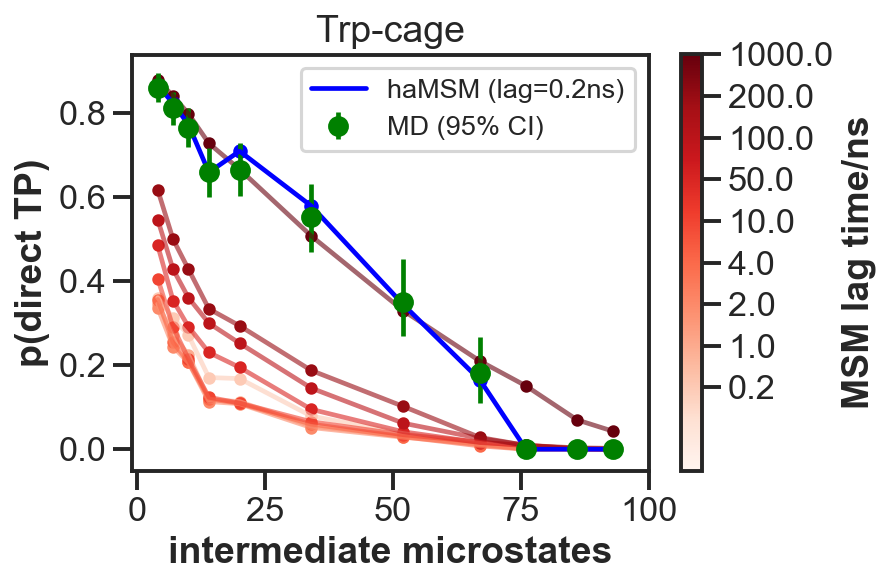

In [39]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,125,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

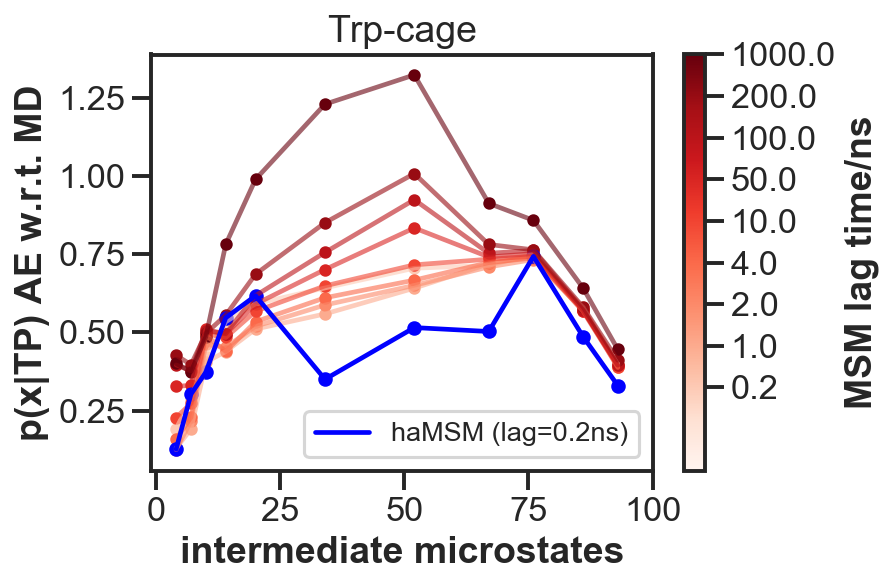

In [40]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs[i][msm_index]) for i in range(len(counts_msms_cutoffs))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(x|TP) AE w.r.t. MD', weight='bold')
plt.xticks(range(0,125,25))
#plt.ylim(-0.05,1.6)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: mean TP length (indirect paths only)

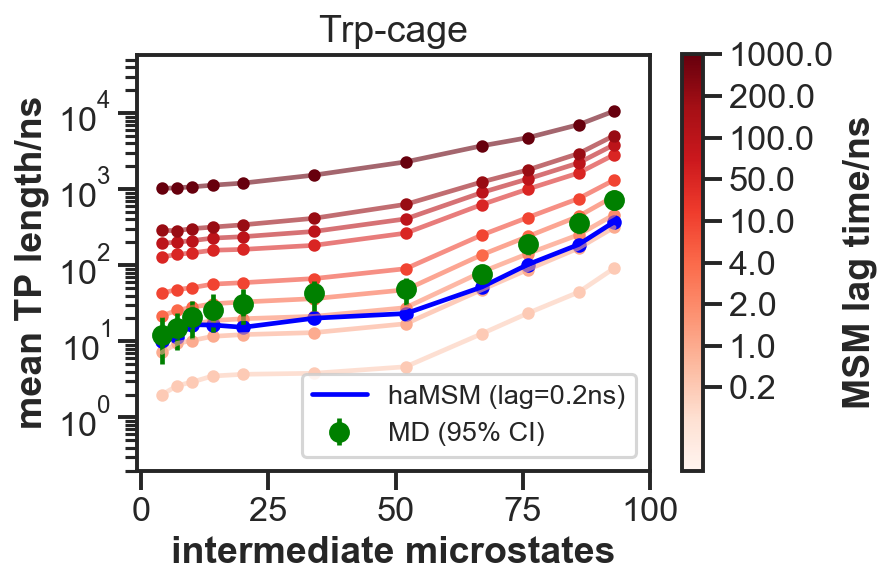

In [41]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,125,25))
plt.ylim(0.2, 5.9e4)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, MSMs trained on stride = lag

## MSMs: estimate and simulate

In [20]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, ([([dtrajs[0][::lag]], 1) for lag in lags]))
pool.close()
pool.join()

msms_strides = [x[0] for x in out]
dtrajs_msms_strides = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms_strides.npy'.format(system_name), dtrajs_msms_strides)
# OR RELOAD
# dtrajs_msms_strides = np.load('{}_dtrajs_msms_strides.npy'.format(system_name), allow_pickle=True)

## MSMs: count

In [21]:
tps_msms_cutoffs_strides = []
pdirect_msms_cutoffs_strides = []
length_msms_cutoffs_strides = []
counts_msms_cutoffs_strides = []

for cutoff in cutoffs:
    
    stateA_= list(get_metastable_sets(cutoff)[system_index][0]) # unfolded
    stateB_ = list(get_metastable_sets(cutoff)[system_index][1]) # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms_strides:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs_strides.append(tps_)
    pdirect_msms_cutoffs_strides.append(pdirect_)
    length_msms_cutoffs_strides.append(length_)
    counts_msms_cutoffs_strides.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs_strides = [x * lags for x in length_msms_cutoffs_strides]

/anaconda3/envs/clean/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/clean/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


There are no indirect TPs!
There are no indirect TPs!
There are no indirect TPs!
There are no indirect TPs!


In [25]:
# all paths
for i in range(len(cutoffs)):
    print([len(tps) for tps in tps_msms_cutoffs_strides[i]])

[908, 1296, 1610, 1688, 2488, 5411, 8746, 17850, 124379]
[892, 1272, 1572, 1662, 2466, 5353, 8660, 17380, 124379]
[892, 1270, 1568, 1660, 2430, 5329, 8590, 17298, 124379]
[854, 1246, 1518, 1626, 2376, 5299, 8448, 16826, 114883]
[854, 1246, 1518, 1622, 2366, 5299, 8426, 16490, 109989]
[848, 1242, 1516, 1620, 2358, 5271, 8382, 16390, 97715]
[846, 1242, 1508, 1618, 2350, 5237, 8313, 16204, 87769]
[834, 1210, 1468, 1584, 2284, 5109, 8083, 15572, 84207]
[778, 1168, 1424, 1536, 2218, 4947, 7751, 14948, 70849]
[728, 1096, 1334, 1458, 2112, 4695, 7419, 14446, 62711]
[646, 952, 1188, 1302, 1908, 4287, 6657, 13032, 38337]


In [26]:
# indirect paths only
for i in range(len(cutoffs)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs_strides[i]])

[569, 846, 1015, 1164, 1541, 2766, 3490, 5747, 0]
[617, 926, 1155, 1344, 1814, 3181, 4375, 8097, 0]
[654, 962, 1171, 1386, 2058, 3608, 5282, 8965, 0]
[715, 1076, 1266, 1450, 2102, 3578, 6107, 10341, 0]
[717, 1080, 1289, 1466, 2140, 3578, 6556, 11848, 13935]
[771, 1178, 1423, 1561, 2266, 4271, 7483, 12689, 40080]
[814, 1210, 1440, 1576, 2258, 4709, 7414, 12503, 49242]
[821, 1196, 1412, 1563, 2241, 4848, 7635, 13690, 50523]
[778, 1168, 1424, 1536, 2175, 4686, 7751, 13966, 51796]
[728, 1096, 1334, 1458, 2112, 4434, 7419, 13464, 48430]
[646, 952, 1188, 1302, 1908, 4287, 6657, 12050, 33625]


## plot: p(direct TP)

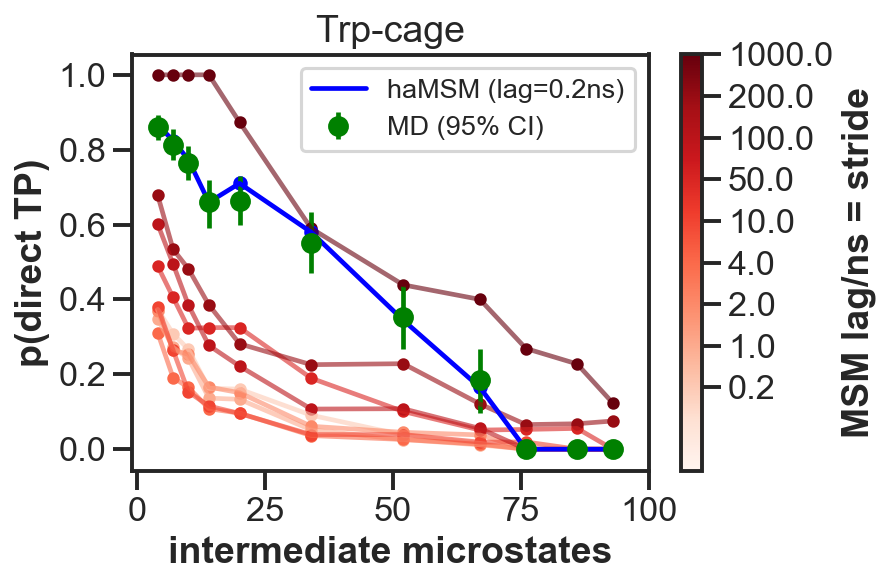

In [22]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs_strides]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,125,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

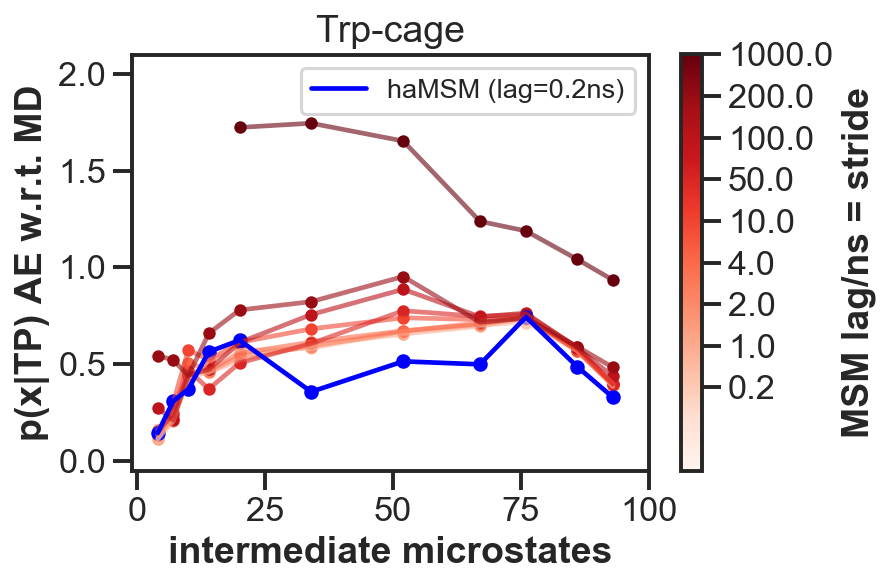

In [23]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs_strides[i][msm_index]) for i in range(len(counts_msms_cutoffs_strides))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')  

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(x|TP) AE w.r.t. MD', weight='bold')
plt.xticks(range(0,125,25))
plt.ylim(-0.05,2.1)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: mean TP length (indirect paths only)

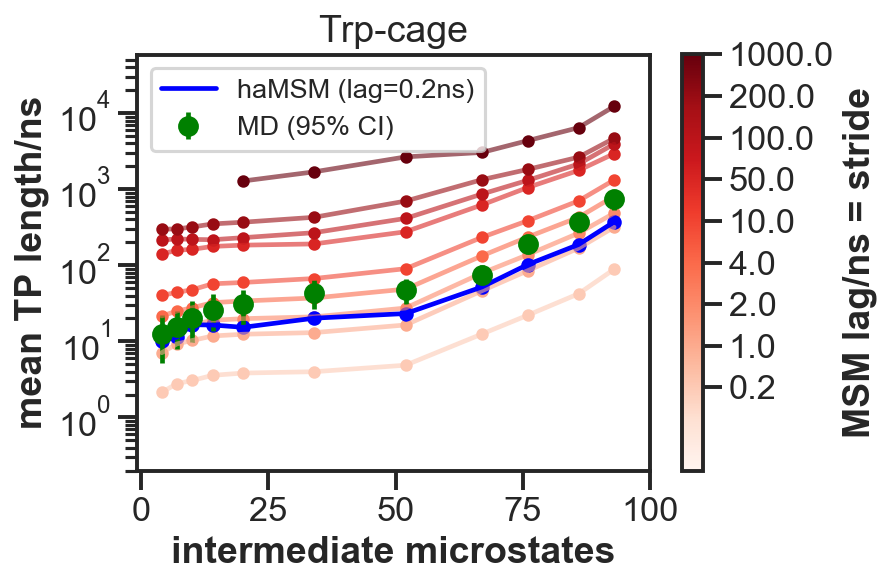

In [24]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs_strides])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold') 

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,125,25))
plt.ylim(0.2, 5.9e4)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()